## Exercice 2 : La Colorisation Automatique

**Objectif :** Prédire les couleurs d'une scène à partir de sa version grise.

* **Dataset :** **Flowers 102** (recommandé pour les couleurs vives), sinon **STL10** ou **CIFAR-10**.
* **Méthode :** Convertissez vos images RGB en niveaux de gris pour l'entrée. Le réseau doit ressortir une image à 3 canaux.
* **Code Noir & Blanc :** `x_train_gray = tf.image.rgb_to_grayscale(x_train)

In [10]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from skimage.color import rgb2lab, lab2rgb

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv2DTranspose

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# --- 2. DATASET POUR LA COLORISATION (FLOWERS 102) ---
# Note : ds_flowers est un dictionnaire contenant 'train', 'test' et 'validation'

DATA_DIR = "datasets/tfds"   # любая папка, например рядом с проектом

ds_flowers, info_flowers = tfds.load(
    'oxford_flowers102',
    data_dir=DATA_DIR,
    with_info=True,
    as_supervised=True
)

In [12]:

print(info_flowers.splits)

{'train': <SplitInfo num_examples=1020, num_shards=1>, 'test': <SplitInfo num_examples=6149, num_shards=2>, 'validation': <SplitInfo num_examples=1020, num_shards=1>}


In [13]:
# Paramètres
BATCH_SIZE = 16
IMG_SIZE = (128, 128) # Redimensionnement automatique 

train_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,            # pour autoencoder / colorisation
    validation_split=0.2,       # 20% pour validation
    subset='training',           # prend pour train
    seed=42                      
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,
    validation_split=0.2,
    subset='validation',         # prend pour val
    seed=42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8189 files.
Using 6552 files for training.
Found 8189 files.
Using 1637 files for validation.


In [14]:
for images in train_ds.take(1):
    print(images.shape)  # 

(16, 128, 128, 3)


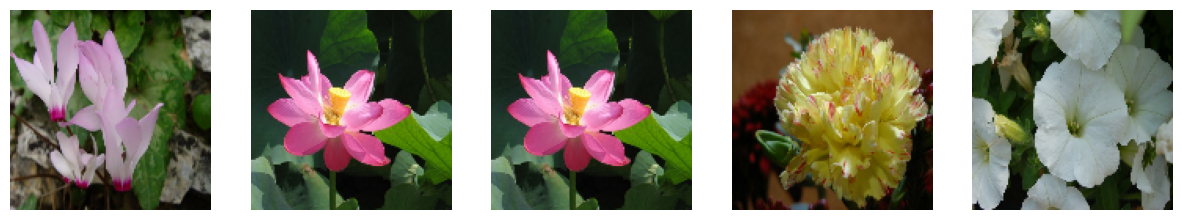

In [15]:
def show_batch_img(ds, n=5):

    for images in ds.take(1):
        fig, axes = plt.subplots(1, n, figsize=(15, 5))
        for i in range(n):
            idx = np.random.randint(images.shape[0]) 
            axes[i].imshow(images[idx].numpy().astype("uint8")) 
            axes[i].axis("off")
        plt.show()
        break

show_batch_img(train_ds, 5)

In [16]:
# --- trnsfomation into gray with normalisation, cration structure: (input, target) ---
from skimage.color import rgb2lab
import tensorflow as tf
import numpy as np

def transform_gray(ds, img_size=(128,128)):


    def rgb_to_lab_batch(batch):
        batch = tf.cast(batch, tf.float32) / 255.0
        batch_np = batch.numpy()
        lab_batch = np.array([rgb2lab(img) for img in batch_np])
        L = lab_batch[..., 0:1] / 100.0
        ab = (lab_batch[..., 1:3] + 128) / 255.0
        return L.astype(np.float32), ab.astype(np.float32)

    def tf_map(batch):
        L, ab = tf.py_function(rgb_to_lab_batch, [batch], [tf.float32, tf.float32])
        # --- фиксируем только H/W/C, оставляем batch_size динамическим ---
        L.set_shape([None, img_size[0], img_size[1], 1])
        ab.set_shape([None, img_size[0], img_size[1], 2])
        return L, ab

    ds_lab = ds.map(tf_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds_lab = ds_lab.prefetch(tf.data.AUTOTUNE)
    return ds_lab



In [30]:

def show_predictions(ds, n=5):
    """
    Визуализация нескольких примеров из Dataset transform_gray:
    - Input (grayscale L)
    - Target (RGB)
    Можно добавить Predicted позже.
    """
    for x_batch, y_batch in ds.take(1):
        batch_size = x_batch.shape[0]
        fig, axes = plt.subplots(2, n, figsize=(15, 6))

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- Input grayscale ---
            gray = x_batch[idx, :, :, 0]
            axes[0, i].imshow(gray, cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Input (L)")

            # --- Target RGB ---
            L = gray * 100.0
            ab_true = y_batch[idx].numpy() * 255.0 - 128.0
            lab_true = np.concatenate([L[..., np.newaxis], ab_true], axis=-1)
            rgb_true = lab2rgb(lab_true)
            axes[1, i].imshow(rgb_true)
            axes[1, i].axis('off')
            axes[1, i].set_title("Target (RGB)")

        plt.show()
        break



In [18]:
# --- trnsfomation into gray with normalisation, cration structure: (input, target) ---
train_gray_ds = transform_gray(train_ds)
val_gray_ds = transform_gray(val_ds)


for x_batch, y_batch in train_gray_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

x_batch shape: (16, 128, 128, 1)
y_batch shape: (16, 128, 128, 2)


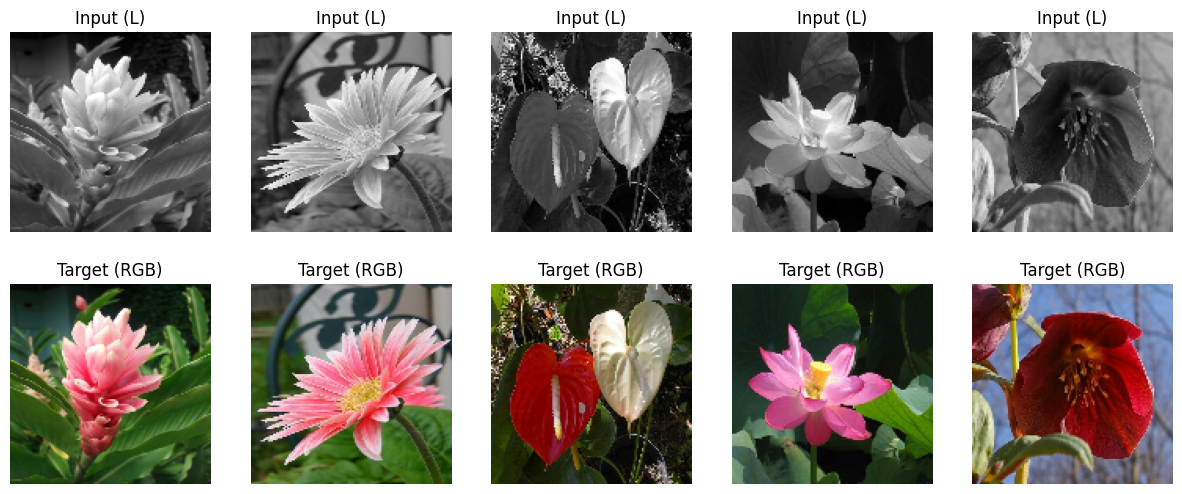

In [19]:
show_predictions(train_gray_ds, n=5)

### --- Model ---

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

def build_lab_unet(img_size=(128,128,1)):

    input_img = Input(shape=img_size)  # L channel

    # -------- Encoder --------
    c1 = Conv2D(64, 3, activation='relu', padding='same')(input_img)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(2, padding='same')(c1)  # 128 - 64
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(2, padding='same')(c2)  # 64 - 32

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(2, padding='same')(c3)  # 32  - 16

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)              # 16
    # no further pooling

    # -------- Decoder --------
    u3 = UpSampling2D(2)(c4)  # 16 - 32
    u3 = Concatenate()([u3, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u3)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D(2)(c5)  # 32 - 64
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)

    u1 = UpSampling2D(2)(c6)  # 64 - 128
    u1 = Concatenate()([u1, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c7 = BatchNormalization()(c7)

    # -------- Output --------
    output_ab = Conv2D(2, 1, activation='tanh')(c7)  # ab channels normalized [-1,1]

    model = Model(input_img, output_ab)
    model.compile(optimizer='adam', loss='mae')

    return model

# создаём модель
IMG_SIZE = (128, 128,1)
model = build_lab_unet(IMG_SIZE)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 3,878,466 (14.80 MB)

 Trainable params: 3,875,650 (14.78 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [21]:
# --- autoencoder fitting ---

history = model.fit(
    train_gray_ds,         
    epochs=5,
    validation_data=val_gray_ds  
)

Epoch 1/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - loss: 0.0999 - val_loss: 0.0961
Epoch 2/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - loss: 0.0637 - val_loss: 0.0732
Epoch 3/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - loss: 0.0616 - val_loss: 0.0671
Epoch 4/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - loss: 0.0608 - val_loss: 0.0659
Epoch 5/5
410/410 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - loss: 0.0598 - val_loss: 0.0647


<Figure size 640x480 with 0 Axes>

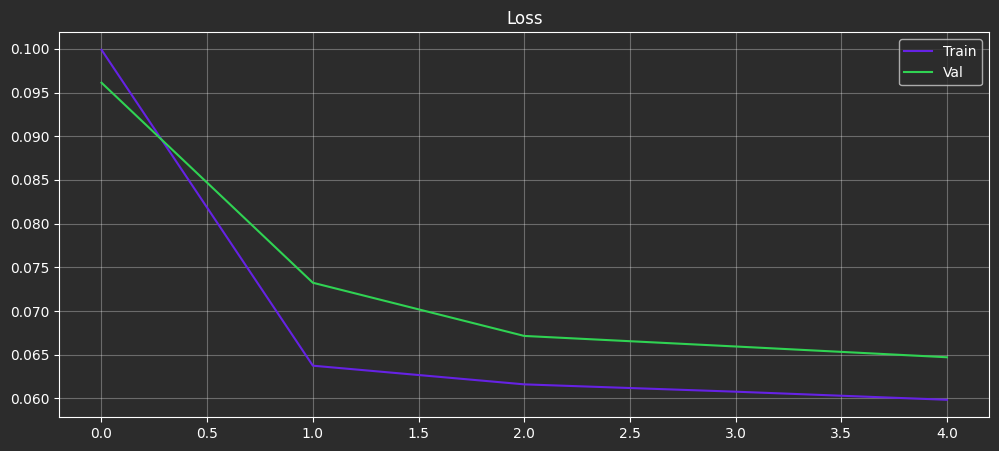

In [22]:
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = "#2c2c2cff"
plt.rcParams['figure.facecolor'] = "#2c2c2cff"

def show_results(history):
    fig, axes = plt.subplots(1, figsize=(12, 5))

    # Loss
    axes.plot(history.history['loss'], color="#6622e4", label='Train')
    axes.plot(history.history['val_loss'], color="#30d353", label='Val')
    axes.set_title('Loss')
    axes.grid(alpha=0.3)
    axes.legend()


plt.tight_layout()
plt.show()

show_results(history)

In [23]:
decoded_imgs = model.predict(train_gray_ds)

410/410 ━━━━━━━━━━━━━━━━━━━━ 193s 470ms/step


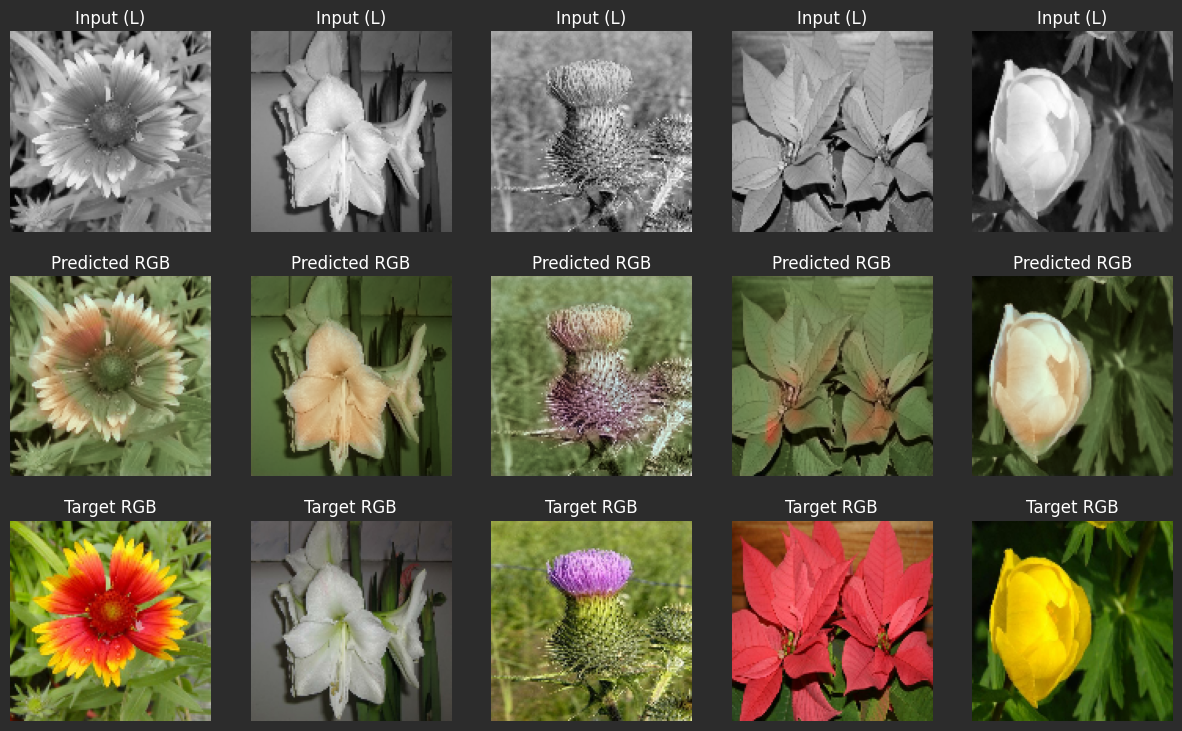

In [36]:
def show_predictions(ds, decoded_imgs, n=5):
    """
    Visualisation:
    - Input (L)
    - Predicted RGB (L + ab_pred)
    - Target RGB (L + ab_true)
    """
    for x_batch, y_batch in ds.take(1):
        batch_size = x_batch.shape[0]
        decoded_batch = decoded_imgs[:batch_size]  # берём первый батч

        fig, axes = plt.subplots(3, n, figsize=(15, 9))

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- Input grayscale ---
            gray = x_batch[idx, :, :, 0]
            axes[0, i].imshow(gray, cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Input (L)")

            # --- Predicted RGB ---
            L = gray * 100.0
            ab_pred = decoded_batch[idx] * 255.0 - 128.0
            lab_pred = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.float32)
            lab_pred[..., 0] = L
            lab_pred[..., 1:] = ab_pred
            rgb_pred = lab2rgb(lab_pred)
            axes[1, i].imshow(rgb_pred)
            axes[1, i].axis('off')
            axes[1, i].set_title("Predicted RGB")

            # --- Target RGB ---
            ab_true = y_batch[idx].numpy() * 255.0 - 128.0
            lab_true = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.float32)
            lab_true[..., 0] = L
            lab_true[..., 1:] = ab_true
            rgb_true = lab2rgb(lab_true)
            axes[2, i].imshow(rgb_true)
            axes[2, i].axis('off')
            axes[2, i].set_title("Target RGB")

        plt.show()
        break


show_predictions(train_gray_ds, decoded_imgs, n=5)


